In [1]:
import scipy.io
import jax.numpy as np
from scipy.io import loadmat 
import numpy as onp
import nibabel as nib
import matplotlib.pyplot as plt 
import os
import shutil
from PIL import Image
from inrmri.bart import bart_acquisition_from_arrays
from inrmri.data_harvard import get_csmaps_and_mask, get_reference_reco
import pandas as pd
from jax import jit, vmap, random
from inrmri.dip import TimeDependant_DIP_Net, helix_generator, circle_generator
from inrmri.new_radon import ForwardRadonOperator
from inrmri.fourier import fastshiftfourier, get_freqs
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import to_complex, is_inside_of_radial_lim, meshgrid_from_subdiv_autolims, total_variation_batch_complex, save_matrix_and_dict_in_zpy, load_matrix_and_dict_from_zpy    
from inrmri.utils import create_exp_file_name, total_variation_complex
import optax 
from inrmri.metrics_rd import mean_psnr, mean_ssim, mean_artifact_power
from inrmri.utils_rdls import seconds_to_min_sec_format, filter_and_get_columns, apply_transform

from inrmri.image_processor import BeforeLinRegNormalizer
from inrmri.basic_plotting import full_halph_FOV_space_time 
from inrmri.image_processor import reduce_FOV 

from inrmri.utils_rdls import safe_normalize, get_center

from inrmri.utils_rdls import get_info_volunteer, read_segmentation, read_ref_dataset

In [2]:
## General

In [42]:
total_slices          = 8
num_frames            = 30
base_path             = '/mnt/workspace/datasets/pulseqCINE/'
target_columns        = ['training_name', 'psnr', 'ssim', 'it', 'duration [min]', 'duration [s]', 'log_psnr', 'log_it', 'log_time', 'log_ssim']

In [43]:
## Volunteer

In [44]:
dataset        = 'DATA_0.55T'
volunteer      = 'MP'
# --- PATH ---
base_folder                     = base_path + dataset + '/' + volunteer + '/'
train_data_folder               = base_folder + 'traindata/'
segmentation_folder             = base_folder + 'segmentations/'

In [45]:
vs_folder = base_folder + 'varying_slices/'
if not os.path.exists(vs_folder):
    os.makedirs(vs_folder)

In [46]:
## DIP Model reconstructions

In [47]:
n_slices_list = [1, 4, 8]

In [50]:
import ast

df_stdip_list         = []
df_stdip_summary_list = []
stDIP_results_list    = []

for n_slice in n_slices_list:
    stdip_parameters = {
        'experiment_name': 'lambda_denoise_reg' + 'n_slices' + str(n_slice), 
        'training_params': {
            'lambda_denoise_reg': 0,
            'slice': 1,
        }
    }
    stdip_parameters['path']               = base_folder + 'stDIP'
    stdip_parameters['csv_path']           = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + ".csv"
    stdip_parameters['csv_path_summary']   = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + "_summary.csv"
    df_stdip                               = pd.read_csv(stdip_parameters['csv_path'] , delimiter=';')
    df_stdip_summary                       = pd.read_csv(stdip_parameters['csv_path_summary'] , delimiter=';')
    stDIP_results                          = filter_and_get_columns(df_stdip, stdip_parameters['training_params'], target_columns)[0]
    # Convert stringified lists to real lists
    for key in ['log_psnr', 'log_it', 'log_time', 'log_ssim']:
        stDIP_results[key] = ast.literal_eval(   stDIP_results[key]    )
    df_stdip_list.append(                        df_stdip              )
    df_stdip_summary_list.append(                df_stdip_summary      )
    stDIP_results_list.append(                   stDIP_results         )

# 1 .- SSIM varing number of slices

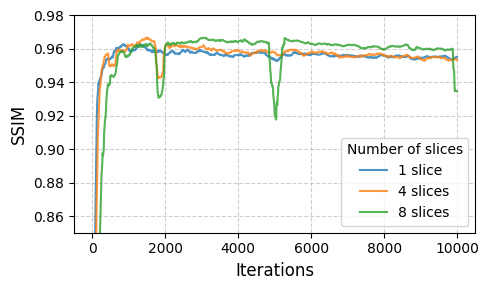

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
import matplotlib.cm as cm

plt.figure(figsize=(5, 3))
window_size = 20

for index, n_slice in enumerate(n_slices_list):
    log_psnr_item = stDIP_results_list[index]['log_ssim']
    log_psnr_it = stDIP_results_list[index]['log_it']
    smoothed_psnr = uniform_filter1d(log_psnr_item, size=window_size)

    label = f'{n_slice} slice' if n_slice == 1 else f'{n_slice} slices'
    plt.plot(log_psnr_it, smoothed_psnr, label=label, linewidth=1.5, alpha=0.8)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('SSIM', fontsize=12)
plt.ylim([0.85, 0.98])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Number of slices')
plt.tight_layout()

plt.savefig("ssim_plot.png", dpi=300, bbox_inches='tight')  # or use .pdf for vector format

plt.show()

# 2 .- PSNR varing number of slices

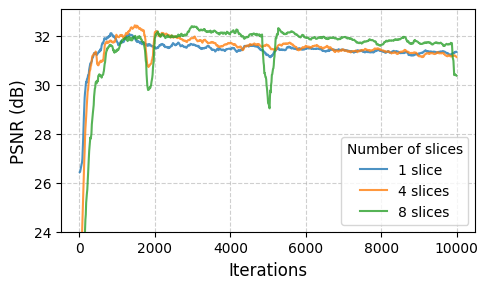

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
import matplotlib.cm as cm

plt.figure(figsize=(5, 3))
window_size = 20

for index, n_slice in enumerate(n_slices_list):
    log_psnr_item = stDIP_results_list[index]['log_psnr']
    log_psnr_it = stDIP_results_list[index]['log_it']
    smoothed_psnr = uniform_filter1d(log_psnr_item, size=window_size)

    label = f'{n_slice} slice' if n_slice == 1 else f'{n_slice} slices'
    plt.plot(log_psnr_it, smoothed_psnr, label=label, linewidth=1.5, alpha=0.8)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.ylim([24, None])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Number of slices')
plt.tight_layout()

plt.savefig("psnr_plot.png", dpi=300, bbox_inches='tight')  # or use .pdf for vector format

plt.show()


# 2 .- Training duration varing number of slices

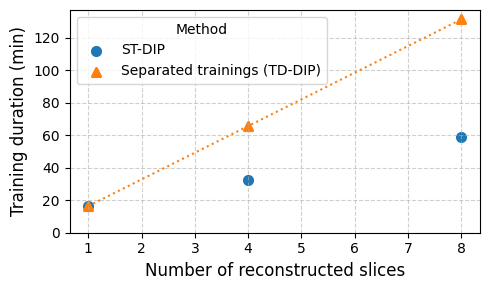

In [68]:
plt.figure(figsize=(5, 3))

duration_min_list = []
duration_min_list_st = []

for index, n_slice in enumerate(n_slices_list):
    duration_min = stDIP_results_list[index]['duration [min]']
    duration_min_list.append(duration_min)
    duration_min_list_st.append(stDIP_results_list[0]['duration [min]'] * n_slice)

# Plotting
scatter_stdip = plt.scatter(n_slices_list, duration_min_list, marker='o', label='ST-DIP', linewidth=2)
scatter_tddip = plt.scatter(n_slices_list, duration_min_list_st, marker='^', label='Separated trainings (TD-DIP)', linewidth=2)

# Match line color to TD-DIP markers
color_td = scatter_tddip.get_facecolor()[0]
plt.plot(n_slices_list, duration_min_list_st, linestyle=':', color=color_td)

# Formatting
plt.xlabel('Number of reconstructed slices', fontsize=12)
plt.ylabel('Training duration (min)', fontsize=12)
plt.ylim([0, None])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Method')
plt.tight_layout()

# Save the figure (optional)
plt.savefig("training_duration_plot.png", dpi=300, bbox_inches='tight')  # or use .pdf for vector format

plt.show()


In [12]:
df_stdip_list[]

,lambda_denoise_reg,duration [s],duration [min],duration,it,loss,mean_var,time,var,ssim,...,training_name,training_folder,slice,log_var,log_ssim,log_psnr,log_ap,log_loss,log_it,log_time
0,0.000000e+00,853.635339,14.227256,0h 14m 13.64s,9299,0.078729,0.000048,794.328222,0.000060,0.960088,...,lambda_denoise_reg=0,/mnt/researchers/claudia-prieto/datasets/pulse...,1,"[0.015385226346552372, 0.0007607406005263329, ...","[0.9060447812080383, 0.9464529156684875, 0.919...","[27.77739906311035, 30.1325626373291, 27.63110...","[0.09654025733470917, 0.05612938478589058, 0.0...","[0.22721898555755615, 0.23283734917640686, 0.2...","[49, 99, 149, 199, 249, 299, 349, 399, 449, 49...","[16.394402742385864, 20.839415550231934, 25.14..."
1,1.000000e-08,853.188832,14.219814,0h 14m 13.19s,8299,0.087128,0.000041,709.186436,0.000047,0.960634,...,lambda_denoise_reg=1e-08,/mnt/researchers/claudia-prieto/datasets/pulse...,1,"[0.015223043970763683, 0.0007441001362167299, ...","[0.9008188843727112, 0.939083993434906, 0.9352...","[27.60251808166504, 29.309894561767578, 28.959...","[0.10050706565380096, 0.06783562898635864, 0.0...","[0.2253561019897461, 0.23866324126720428, 0.22...","[49, 99, 149, 199, 249, 299, 349, 399, 449, 49...","[14.001188278198242, 18.315826892852783, 22.58..."
2,1.000000e-07,858.489545,14.308159,0h 14m 18.49s,8449,0.085172,0.000036,725.943117,0.000052,0.967074,...,lambda_denoise_reg=1e-07,/mnt/researchers/claudia-prieto/datasets/pulse...,1,"[0.01488201692700386, 0.000661510624922812, 0....","[0.899644136428833, 0.945310652256012, 0.93915...","[27.561399459838867, 29.821731567382812, 29.15...","[0.10146315395832062, 0.060293931514024734, 0....","[0.23928537964820862, 0.2420249730348587, 0.23...","[49, 99, 149, 199, 249, 299, 349, 399, 449, 49...","[13.900108337402344, 18.26238250732422, 22.538..."
